# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('Ctrl-r', {
    help : 'tooltip',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_cell();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [2]:
%config IPCompleter

IPCompleter options
-----------------
IPCompleter.greedy=<Bool>
    Current: False
    Activate greedy completion PENDING DEPRECTION. this is now mostly taken care
    of with Jedi.
    This will enable completion on elements of lists, results of function calls,
    etc., but can be unsafe because the code is actually evaluated on TAB.
IPCompleter.limit_to__all__=<Bool>
    Current: False
    DEPRECATED as of version 5.0.
    Instruct the completer to use __all__ for the completion
    Specifically, when completing on ``object.<tab>``.
    When True: only those names in obj.__all__ will be included.
    When False [default]: the __all__ attribute is ignored
IPCompleter.merge_completions=<Bool>
    Current: True
    Whether to merge completion results into a single list
    If False, only the completion results from the first non-empty completer
    will be returned.
IPCompleter.omit__names=<Enum>
    Current: 2
    Choices: (0, 1, 2)
    Instruct the completer to omit private method na

In [3]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('Ctrl-r', 'jupyter-notebook:change-cell-to-raw');

<IPython.core.display.Javascript object>

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

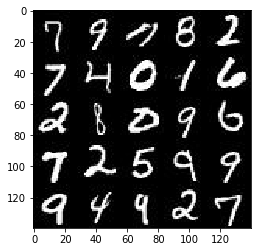

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

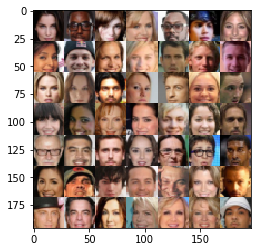

In [6]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [91]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [92]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_ = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels))
    z_ = tf.placeholder(tf.float32, (None, z_dim))
    lr_ = tf.placeholder(tf.float32)
    return input_, z_, lr_

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)
                            

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [93]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same')
        layer1 = tf.maximum(layer1, alpha*layer1)
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(layer2, alpha*layer2)
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(layer3, alpha*layer3)
        
        layer4 = tf.layers.conv2d(layer3, 512, 3, strides=2, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=True)
        layer4 = tf.maximum(layer4, alpha*layer4)
        
        layer4 = tf.reshape(layer4, (-1, 8192))

        logits = tf.layers.dense(layer4, 1)
        
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [94]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        layer1 = tf.layers.dense(z, 6272)
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 128))
        layer1 = tf.maximum(layer1, alpha*layer1)

        layer2 = tf.layers.conv2d_transpose(layer1, 128, 3, strides=1, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(layer2, alpha*layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(layer3, alpha*layer3)
        
        layer4 = tf.layers.conv2d_transpose(layer3, 32, 5, strides=2, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.maximum(layer4, alpha*layer4)
        
        layer5 = tf.layers.conv2d_transpose(layer4, out_channel_dim, 5, strides=1, padding='same')
        
        output = tf.nn.tanh(layer5)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [95]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)a
    """
    input_fake = generator(input_z, out_channel_dim)
    real_output, real_logits = discriminator(input_real, reuse=False)
    fake_output, fake_logits = discriminator(input_fake, reuse=True)

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_output),
                                                                    logits=fake_logits))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output)*0.8,
                                                                         logits=real_logits))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_output),
                                                                         logits=fake_logits))
    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [96]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [97]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [100]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if data_image_mode == 'L':
        image_channels = 1
    else:
        image_channels = 3
    input_, z_, lr_ = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_, z_, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_count = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                input_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={input_:batch_images, z_:input_z, lr_:learning_rate})
                sess.run(g_opt, feed_dict={input_:batch_images, z_:input_z, lr_:learning_rate})
                batch_count += 1
                if (batch_count % 10 == 0):
                    print('Epoch ', epoch_i, '- Completed ',batch_count,' batches')
                    print('Discriminator Loss: ',d_loss.eval(feed_dict={input_:batch_images, z_:input_z}))
                    print('Generator Loss: ',g_loss.eval(feed_dict={input_:batch_images, z_:input_z}))
                if (batch_count % 100 == 0):
                    test_input_z = np.random.uniform(-1, 1, size=(25, z_dim))
                    show_generator_output(sess, 25, tf.constant(test_input_z, dtype=tf.float32), image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
Epoch  0 - Completed  10  batches
Discriminator Loss:  5.3769
Generator Loss:  21.5952
Epoch  0 - Completed  20  batches
Discriminator Loss:  1.30754
Generator Loss:  0.993748
Epoch  0 - Completed  30  batches
Discriminator Loss:  1.17121
Generator Loss:  1.78343
Epoch  0 - Completed  40  batches
Discriminator Loss:  1.4732
Generator Loss:  0.613497
Epoch  0 - Completed  50  batches
Discriminator Loss:  1.67296
Generator Loss:  0.451697
Epoch  0 - Completed  60  batches
Discriminator Loss:  1.71615
Generator Loss:  2.78691
Epoch  0 - Completed  70  batches
Discriminator Loss:  1.35571
Generator Loss:  0.668609
Epoch  0 - Completed  80  batches
Discriminator Loss:  1.2853
Generator Loss:  2.12108
Epoch  0 - Completed  90  batches
Discriminator Loss:  1.59841
Generator Loss:  2.73734
Epoch  0 - Completed  100  batches
Discriminator Loss:  1.53919
Generator Loss:  2.3858


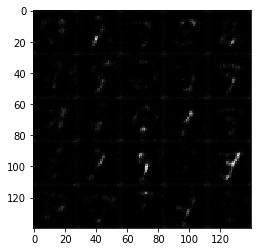

Epoch  0 - Completed  110  batches
Discriminator Loss:  1.16699
Generator Loss:  0.892768
Epoch  0 - Completed  120  batches
Discriminator Loss:  1.36415
Generator Loss:  0.669899
Epoch  0 - Completed  130  batches
Discriminator Loss:  1.9281
Generator Loss:  3.08453
Epoch  0 - Completed  140  batches
Discriminator Loss:  1.40022
Generator Loss:  0.663698
Epoch  0 - Completed  150  batches
Discriminator Loss:  1.50199
Generator Loss:  0.580702
Epoch  0 - Completed  160  batches
Discriminator Loss:  1.43909
Generator Loss:  0.591508
Epoch  0 - Completed  170  batches
Discriminator Loss:  1.56374
Generator Loss:  0.531818
Epoch  0 - Completed  180  batches
Discriminator Loss:  1.3216
Generator Loss:  0.676776
Epoch  0 - Completed  190  batches
Discriminator Loss:  1.70818
Generator Loss:  2.93916
Epoch  0 - Completed  200  batches
Discriminator Loss:  1.53504
Generator Loss:  0.562524


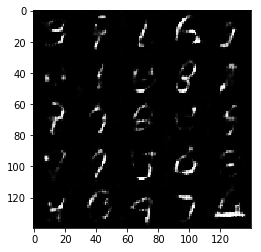

Epoch  0 - Completed  210  batches
Discriminator Loss:  1.90453
Generator Loss:  3.15936
Epoch  0 - Completed  220  batches
Discriminator Loss:  1.26026
Generator Loss:  0.873554
Epoch  0 - Completed  230  batches
Discriminator Loss:  1.25972
Generator Loss:  0.773601
Epoch  0 - Completed  240  batches
Discriminator Loss:  1.16724
Generator Loss:  1.40091
Epoch  0 - Completed  250  batches
Discriminator Loss:  1.56579
Generator Loss:  2.78785
Epoch  0 - Completed  260  batches
Discriminator Loss:  1.71454
Generator Loss:  0.484105
Epoch  0 - Completed  270  batches
Discriminator Loss:  1.16025
Generator Loss:  0.926703
Epoch  0 - Completed  280  batches
Discriminator Loss:  1.24553
Generator Loss:  0.789618
Epoch  0 - Completed  290  batches
Discriminator Loss:  1.33674
Generator Loss:  2.15542
Epoch  0 - Completed  300  batches
Discriminator Loss:  2.42654
Generator Loss:  0.209669


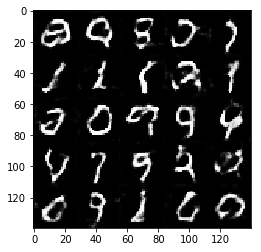

Epoch  0 - Completed  310  batches
Discriminator Loss:  1.12862
Generator Loss:  0.993203
Epoch  0 - Completed  320  batches
Discriminator Loss:  2.73689
Generator Loss:  3.51249
Epoch  0 - Completed  330  batches
Discriminator Loss:  1.41569
Generator Loss:  0.618318
Epoch  0 - Completed  340  batches
Discriminator Loss:  1.29005
Generator Loss:  0.823067
Epoch  0 - Completed  350  batches
Discriminator Loss:  1.15729
Generator Loss:  1.10838
Epoch  0 - Completed  360  batches
Discriminator Loss:  1.19058
Generator Loss:  0.85083
Epoch  0 - Completed  370  batches
Discriminator Loss:  1.06979
Generator Loss:  1.321
Epoch  0 - Completed  380  batches
Discriminator Loss:  1.72422
Generator Loss:  2.34516
Epoch  0 - Completed  390  batches
Discriminator Loss:  1.18599
Generator Loss:  0.973346
Epoch  0 - Completed  400  batches
Discriminator Loss:  1.32275
Generator Loss:  1.99236


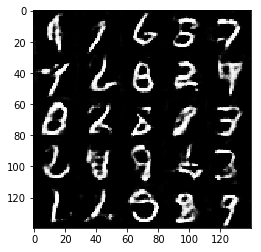

Epoch  0 - Completed  410  batches
Discriminator Loss:  1.12525
Generator Loss:  1.7658
Epoch  0 - Completed  420  batches
Discriminator Loss:  5.01669
Generator Loss:  6.79376
Epoch  0 - Completed  430  batches
Discriminator Loss:  1.19192
Generator Loss:  1.457
Epoch  0 - Completed  440  batches
Discriminator Loss:  1.30685
Generator Loss:  0.744884
Epoch  0 - Completed  450  batches
Discriminator Loss:  1.33439
Generator Loss:  0.691504
Epoch  0 - Completed  460  batches
Discriminator Loss:  1.13365
Generator Loss:  1.42054
Epoch  1 - Completed  10  batches
Discriminator Loss:  1.60148
Generator Loss:  0.496991
Epoch  1 - Completed  20  batches
Discriminator Loss:  1.17646
Generator Loss:  0.952917
Epoch  1 - Completed  30  batches
Discriminator Loss:  1.37572
Generator Loss:  1.71293
Epoch  1 - Completed  40  batches
Discriminator Loss:  1.41532
Generator Loss:  0.606586
Epoch  1 - Completed  50  batches
Discriminator Loss:  1.05723
Generator Loss:  1.06158
Epoch  1 - Completed  60

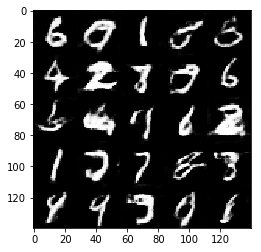

Epoch  1 - Completed  110  batches
Discriminator Loss:  1.63219
Generator Loss:  0.519986
Epoch  1 - Completed  120  batches
Discriminator Loss:  1.17483
Generator Loss:  2.03249
Epoch  1 - Completed  130  batches
Discriminator Loss:  1.29835
Generator Loss:  0.773254
Epoch  1 - Completed  140  batches
Discriminator Loss:  1.06937
Generator Loss:  1.65825
Epoch  1 - Completed  150  batches
Discriminator Loss:  1.11943
Generator Loss:  1.53031
Epoch  1 - Completed  160  batches
Discriminator Loss:  1.13202
Generator Loss:  1.43581
Epoch  1 - Completed  170  batches
Discriminator Loss:  1.13589
Generator Loss:  0.970895
Epoch  1 - Completed  180  batches
Discriminator Loss:  1.65804
Generator Loss:  0.498326
Epoch  1 - Completed  190  batches
Discriminator Loss:  1.12093
Generator Loss:  1.02601
Epoch  1 - Completed  200  batches
Discriminator Loss:  1.02894
Generator Loss:  1.30073


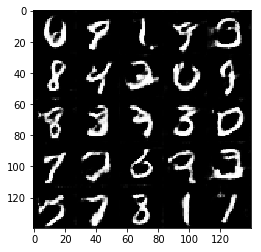

Epoch  1 - Completed  210  batches
Discriminator Loss:  1.24091
Generator Loss:  1.87945
Epoch  1 - Completed  220  batches
Discriminator Loss:  1.2944
Generator Loss:  0.730563
Epoch  1 - Completed  230  batches
Discriminator Loss:  1.08203
Generator Loss:  1.17908
Epoch  1 - Completed  240  batches
Discriminator Loss:  1.09774
Generator Loss:  1.03429
Epoch  1 - Completed  250  batches
Discriminator Loss:  0.988719
Generator Loss:  1.47238
Epoch  1 - Completed  260  batches
Discriminator Loss:  1.30002
Generator Loss:  0.898302
Epoch  1 - Completed  270  batches
Discriminator Loss:  1.16065
Generator Loss:  1.12122
Epoch  1 - Completed  280  batches
Discriminator Loss:  1.22038
Generator Loss:  0.897186
Epoch  1 - Completed  290  batches
Discriminator Loss:  1.45802
Generator Loss:  2.26783
Epoch  1 - Completed  300  batches
Discriminator Loss:  1.23171
Generator Loss:  0.776931


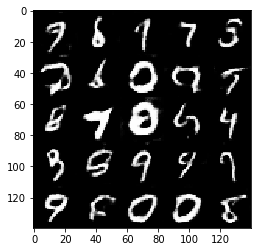

Epoch  1 - Completed  310  batches
Discriminator Loss:  1.11338
Generator Loss:  1.18152
Epoch  1 - Completed  320  batches
Discriminator Loss:  2.23139
Generator Loss:  0.294678
Epoch  1 - Completed  330  batches
Discriminator Loss:  1.10215
Generator Loss:  1.06756
Epoch  1 - Completed  340  batches
Discriminator Loss:  1.16026
Generator Loss:  0.871337
Epoch  1 - Completed  350  batches
Discriminator Loss:  1.20353
Generator Loss:  1.08913
Epoch  1 - Completed  360  batches
Discriminator Loss:  1.25245
Generator Loss:  0.807795
Epoch  1 - Completed  370  batches
Discriminator Loss:  1.47064
Generator Loss:  0.57624
Epoch  1 - Completed  380  batches
Discriminator Loss:  1.24247
Generator Loss:  1.91111
Epoch  1 - Completed  390  batches
Discriminator Loss:  1.25235
Generator Loss:  0.78598
Epoch  1 - Completed  400  batches
Discriminator Loss:  2.95739
Generator Loss:  3.63101


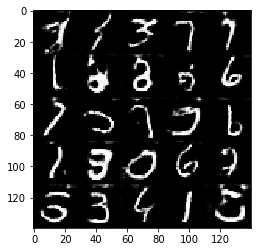

Epoch  1 - Completed  410  batches
Discriminator Loss:  1.13455
Generator Loss:  1.16437
Epoch  1 - Completed  420  batches
Discriminator Loss:  0.978642
Generator Loss:  1.43348
Epoch  1 - Completed  430  batches
Discriminator Loss:  1.2668
Generator Loss:  2.66098
Epoch  1 - Completed  440  batches
Discriminator Loss:  1.04261
Generator Loss:  1.12199
Epoch  1 - Completed  450  batches
Discriminator Loss:  1.3234
Generator Loss:  0.70507
Epoch  1 - Completed  460  batches
Discriminator Loss:  1.12618
Generator Loss:  0.968664


In [101]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape, mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch  0 - Completed  10  batches
Discriminator Loss:  2.71599
Generator Loss:  0.682689
Epoch  0 - Completed  20  batches
Discriminator Loss:  2.10866
Generator Loss:  3.82633
Epoch  0 - Completed  30  batches
Discriminator Loss:  0.961133
Generator Loss:  1.24228
Epoch  0 - Completed  40  batches
Discriminator Loss:  1.61849
Generator Loss:  3.12535
Epoch  0 - Completed  50  batches
Discriminator Loss:  1.31463
Generator Loss:  1.55348
Epoch  0 - Completed  60  batches
Discriminator Loss:  1.51809
Generator Loss:  1.96603
Epoch  0 - Completed  70  batches
Discriminator Loss:  1.09997
Generator Loss:  1.25673
Epoch  0 - Completed  80  batches
Discriminator Loss:  0.979276
Generator Loss:  1.17044
Epoch  0 - Completed  90  batches
Discriminator Loss:  1.15517
Generator Loss:  1.27297
Epoch  0 - Completed  100  batches
Discriminator Loss:  1.2827
Generator Loss:  0.922901


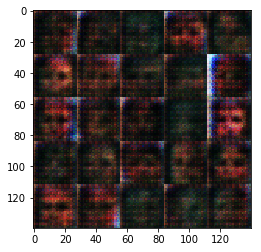

Epoch  0 - Completed  110  batches
Discriminator Loss:  1.48691
Generator Loss:  0.962401
Epoch  0 - Completed  120  batches
Discriminator Loss:  1.17753
Generator Loss:  0.893058
Epoch  0 - Completed  130  batches
Discriminator Loss:  1.27923
Generator Loss:  0.692688
Epoch  0 - Completed  140  batches
Discriminator Loss:  1.15024
Generator Loss:  1.13437
Epoch  0 - Completed  150  batches
Discriminator Loss:  1.32012
Generator Loss:  1.92561
Epoch  0 - Completed  160  batches
Discriminator Loss:  1.52448
Generator Loss:  0.736987
Epoch  0 - Completed  170  batches
Discriminator Loss:  1.13834
Generator Loss:  0.951617
Epoch  0 - Completed  180  batches
Discriminator Loss:  0.919839
Generator Loss:  1.37807
Epoch  0 - Completed  190  batches
Discriminator Loss:  0.993241
Generator Loss:  1.22067
Epoch  0 - Completed  200  batches
Discriminator Loss:  1.61052
Generator Loss:  0.677412


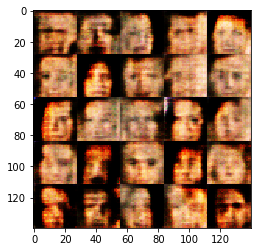

Epoch  0 - Completed  210  batches
Discriminator Loss:  1.16563
Generator Loss:  0.856128
Epoch  0 - Completed  220  batches
Discriminator Loss:  1.4278
Generator Loss:  0.670568
Epoch  0 - Completed  230  batches
Discriminator Loss:  1.19245
Generator Loss:  0.803586
Epoch  0 - Completed  240  batches
Discriminator Loss:  1.13614
Generator Loss:  1.36227
Epoch  0 - Completed  250  batches
Discriminator Loss:  1.12398
Generator Loss:  1.42458
Epoch  0 - Completed  260  batches
Discriminator Loss:  1.22752
Generator Loss:  1.18333
Epoch  0 - Completed  270  batches
Discriminator Loss:  1.23121
Generator Loss:  2.76327
Epoch  0 - Completed  280  batches
Discriminator Loss:  1.23242
Generator Loss:  1.60594
Epoch  0 - Completed  290  batches
Discriminator Loss:  1.53719
Generator Loss:  2.39633
Epoch  0 - Completed  300  batches
Discriminator Loss:  1.31776
Generator Loss:  0.848452


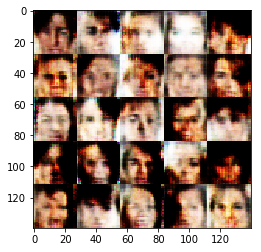

Epoch  0 - Completed  310  batches
Discriminator Loss:  1.46788
Generator Loss:  0.699326
Epoch  0 - Completed  320  batches
Discriminator Loss:  0.886803
Generator Loss:  1.6092
Epoch  0 - Completed  330  batches
Discriminator Loss:  1.29725
Generator Loss:  0.962825
Epoch  0 - Completed  340  batches
Discriminator Loss:  0.755071
Generator Loss:  1.79315
Epoch  0 - Completed  350  batches
Discriminator Loss:  1.47411
Generator Loss:  1.22489
Epoch  0 - Completed  360  batches
Discriminator Loss:  1.35627
Generator Loss:  1.33591
Epoch  0 - Completed  370  batches
Discriminator Loss:  1.25514
Generator Loss:  0.986359
Epoch  0 - Completed  380  batches
Discriminator Loss:  1.28842
Generator Loss:  1.94646
Epoch  0 - Completed  390  batches
Discriminator Loss:  1.32533
Generator Loss:  0.980452
Epoch  0 - Completed  400  batches
Discriminator Loss:  1.01475
Generator Loss:  1.14061


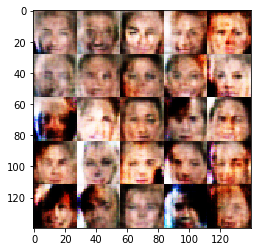

Epoch  0 - Completed  410  batches
Discriminator Loss:  0.82496
Generator Loss:  1.72845
Epoch  0 - Completed  420  batches
Discriminator Loss:  1.49031
Generator Loss:  0.651238
Epoch  0 - Completed  430  batches
Discriminator Loss:  1.2806
Generator Loss:  1.24644
Epoch  0 - Completed  440  batches
Discriminator Loss:  1.53795
Generator Loss:  1.86955
Epoch  0 - Completed  450  batches
Discriminator Loss:  2.12164
Generator Loss:  2.55877
Epoch  0 - Completed  460  batches
Discriminator Loss:  1.35796
Generator Loss:  0.934094
Epoch  0 - Completed  470  batches
Discriminator Loss:  1.03831
Generator Loss:  2.46687
Epoch  0 - Completed  480  batches
Discriminator Loss:  1.53582
Generator Loss:  0.57128
Epoch  0 - Completed  490  batches
Discriminator Loss:  2.04401
Generator Loss:  0.429975
Epoch  0 - Completed  500  batches
Discriminator Loss:  1.13761
Generator Loss:  1.27138


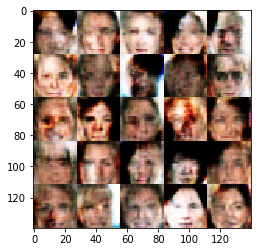

Epoch  0 - Completed  510  batches
Discriminator Loss:  1.02812
Generator Loss:  1.44451
Epoch  0 - Completed  520  batches
Discriminator Loss:  3.30268
Generator Loss:  0.0929495
Epoch  0 - Completed  530  batches
Discriminator Loss:  1.17386
Generator Loss:  1.08249
Epoch  0 - Completed  540  batches
Discriminator Loss:  1.3059
Generator Loss:  0.958316
Epoch  0 - Completed  550  batches
Discriminator Loss:  1.38269
Generator Loss:  1.69472
Epoch  0 - Completed  560  batches
Discriminator Loss:  1.28156
Generator Loss:  0.813376
Epoch  0 - Completed  570  batches
Discriminator Loss:  1.13726
Generator Loss:  1.06041
Epoch  0 - Completed  580  batches
Discriminator Loss:  0.871954
Generator Loss:  1.66706
Epoch  0 - Completed  590  batches
Discriminator Loss:  0.968828
Generator Loss:  1.8701
Epoch  0 - Completed  600  batches
Discriminator Loss:  1.53228
Generator Loss:  1.19281


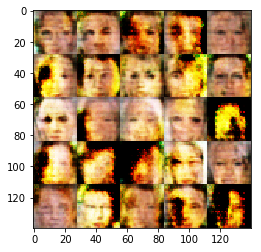

Epoch  0 - Completed  610  batches
Discriminator Loss:  1.28401
Generator Loss:  1.04545
Epoch  0 - Completed  620  batches
Discriminator Loss:  1.50058
Generator Loss:  0.761684
Epoch  0 - Completed  630  batches
Discriminator Loss:  1.50893
Generator Loss:  1.42536
Epoch  0 - Completed  640  batches
Discriminator Loss:  1.03002
Generator Loss:  1.31798
Epoch  0 - Completed  650  batches
Discriminator Loss:  1.24325
Generator Loss:  0.874157
Epoch  0 - Completed  660  batches
Discriminator Loss:  1.08825
Generator Loss:  1.18872
Epoch  0 - Completed  670  batches
Discriminator Loss:  1.08187
Generator Loss:  1.42287
Epoch  0 - Completed  680  batches
Discriminator Loss:  0.925262
Generator Loss:  1.6885
Epoch  0 - Completed  690  batches
Discriminator Loss:  2.26564
Generator Loss:  0.321692
Epoch  0 - Completed  700  batches
Discriminator Loss:  1.3978
Generator Loss:  1.1603


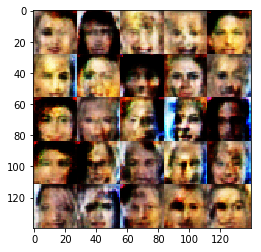

Epoch  0 - Completed  710  batches
Discriminator Loss:  1.17509
Generator Loss:  1.25023
Epoch  0 - Completed  720  batches
Discriminator Loss:  1.27955
Generator Loss:  0.813612
Epoch  0 - Completed  730  batches
Discriminator Loss:  1.825
Generator Loss:  0.473455
Epoch  0 - Completed  740  batches
Discriminator Loss:  1.20584
Generator Loss:  1.11037
Epoch  0 - Completed  750  batches
Discriminator Loss:  1.09821
Generator Loss:  2.2697
Epoch  0 - Completed  760  batches
Discriminator Loss:  1.33611
Generator Loss:  0.790995
Epoch  0 - Completed  770  batches
Discriminator Loss:  1.9956
Generator Loss:  2.419
Epoch  0 - Completed  780  batches
Discriminator Loss:  1.44965
Generator Loss:  0.684687
Epoch  0 - Completed  790  batches
Discriminator Loss:  1.48215
Generator Loss:  0.77369
Epoch  0 - Completed  800  batches
Discriminator Loss:  1.17717
Generator Loss:  1.2994


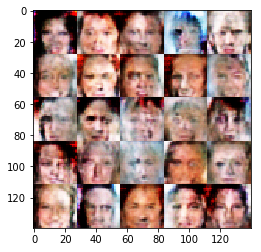

Epoch  0 - Completed  810  batches
Discriminator Loss:  1.13721
Generator Loss:  1.70772
Epoch  0 - Completed  820  batches
Discriminator Loss:  1.61524
Generator Loss:  0.514838
Epoch  0 - Completed  830  batches
Discriminator Loss:  1.94549
Generator Loss:  0.357259
Epoch  0 - Completed  840  batches
Discriminator Loss:  1.10899
Generator Loss:  1.11157
Epoch  0 - Completed  850  batches
Discriminator Loss:  3.13193
Generator Loss:  2.63598
Epoch  0 - Completed  860  batches
Discriminator Loss:  1.34612
Generator Loss:  1.08924
Epoch  0 - Completed  870  batches
Discriminator Loss:  1.37582
Generator Loss:  1.03018
Epoch  0 - Completed  880  batches
Discriminator Loss:  1.48528
Generator Loss:  1.10147
Epoch  0 - Completed  890  batches
Discriminator Loss:  1.34238
Generator Loss:  0.930406
Epoch  0 - Completed  900  batches
Discriminator Loss:  1.42354
Generator Loss:  1.33265


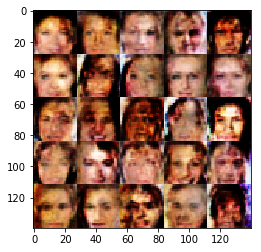

Epoch  0 - Completed  910  batches
Discriminator Loss:  1.32109
Generator Loss:  0.772008
Epoch  0 - Completed  920  batches
Discriminator Loss:  1.36194
Generator Loss:  1.3314
Epoch  0 - Completed  930  batches
Discriminator Loss:  1.39607
Generator Loss:  1.13922
Epoch  0 - Completed  940  batches
Discriminator Loss:  1.33081
Generator Loss:  1.1987
Epoch  0 - Completed  950  batches
Discriminator Loss:  1.45504
Generator Loss:  1.41709
Epoch  0 - Completed  960  batches
Discriminator Loss:  1.28191
Generator Loss:  1.04055
Epoch  0 - Completed  970  batches
Discriminator Loss:  1.3123
Generator Loss:  1.46787
Epoch  0 - Completed  980  batches
Discriminator Loss:  1.09007
Generator Loss:  1.01623
Epoch  0 - Completed  990  batches
Discriminator Loss:  1.04631
Generator Loss:  1.0096
Epoch  0 - Completed  1000  batches
Discriminator Loss:  1.36111
Generator Loss:  0.983953


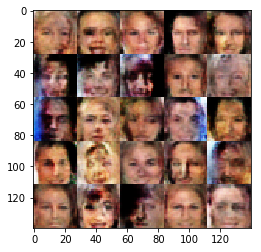

Epoch  0 - Completed  1010  batches
Discriminator Loss:  1.21476
Generator Loss:  1.31397
Epoch  0 - Completed  1020  batches
Discriminator Loss:  1.07283
Generator Loss:  1.15187
Epoch  0 - Completed  1030  batches
Discriminator Loss:  1.10676
Generator Loss:  1.30733
Epoch  0 - Completed  1040  batches
Discriminator Loss:  0.894919
Generator Loss:  1.66513
Epoch  0 - Completed  1050  batches
Discriminator Loss:  0.831889
Generator Loss:  1.76487
Epoch  0 - Completed  1060  batches
Discriminator Loss:  3.66345
Generator Loss:  0.126854
Epoch  0 - Completed  1070  batches
Discriminator Loss:  1.74828
Generator Loss:  2.05248
Epoch  0 - Completed  1080  batches
Discriminator Loss:  1.29604
Generator Loss:  1.03758
Epoch  0 - Completed  1090  batches
Discriminator Loss:  1.31034
Generator Loss:  0.900414
Epoch  0 - Completed  1100  batches
Discriminator Loss:  1.28463
Generator Loss:  0.881624


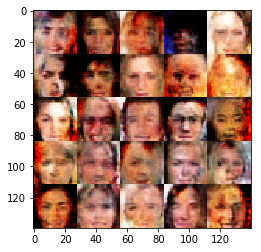

Epoch  0 - Completed  1110  batches
Discriminator Loss:  1.27504
Generator Loss:  0.960905
Epoch  0 - Completed  1120  batches
Discriminator Loss:  1.63771
Generator Loss:  1.04536
Epoch  0 - Completed  1130  batches
Discriminator Loss:  1.36084
Generator Loss:  0.905354
Epoch  0 - Completed  1140  batches
Discriminator Loss:  1.2824
Generator Loss:  1.15649
Epoch  0 - Completed  1150  batches
Discriminator Loss:  1.31781
Generator Loss:  1.06789
Epoch  0 - Completed  1160  batches
Discriminator Loss:  1.86744
Generator Loss:  1.80108
Epoch  0 - Completed  1170  batches
Discriminator Loss:  1.19335
Generator Loss:  1.19193
Epoch  0 - Completed  1180  batches
Discriminator Loss:  1.27396
Generator Loss:  1.05102
Epoch  0 - Completed  1190  batches
Discriminator Loss:  1.53623
Generator Loss:  0.681605
Epoch  0 - Completed  1200  batches
Discriminator Loss:  1.39805
Generator Loss:  1.14786


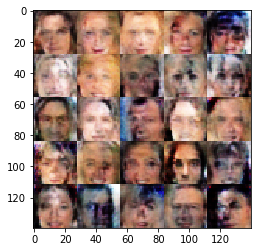

Epoch  0 - Completed  1210  batches
Discriminator Loss:  1.23465
Generator Loss:  1.13402
Epoch  0 - Completed  1220  batches
Discriminator Loss:  1.0848
Generator Loss:  1.11664
Epoch  0 - Completed  1230  batches
Discriminator Loss:  1.10647
Generator Loss:  0.982009
Epoch  0 - Completed  1240  batches
Discriminator Loss:  1.30716
Generator Loss:  1.14426
Epoch  0 - Completed  1250  batches
Discriminator Loss:  1.14925
Generator Loss:  1.09714
Epoch  0 - Completed  1260  batches
Discriminator Loss:  1.15019
Generator Loss:  0.930197
Epoch  0 - Completed  1270  batches
Discriminator Loss:  1.18293
Generator Loss:  1.65063
Epoch  0 - Completed  1280  batches
Discriminator Loss:  1.30644
Generator Loss:  1.04414
Epoch  0 - Completed  1290  batches
Discriminator Loss:  1.38294
Generator Loss:  1.08791
Epoch  0 - Completed  1300  batches
Discriminator Loss:  1.45302
Generator Loss:  1.53839


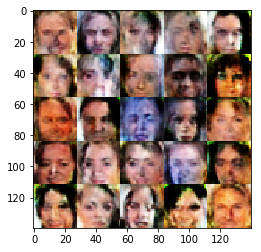

Epoch  0 - Completed  1310  batches
Discriminator Loss:  1.2175
Generator Loss:  0.850001
Epoch  0 - Completed  1320  batches
Discriminator Loss:  1.27729
Generator Loss:  1.00076
Epoch  0 - Completed  1330  batches
Discriminator Loss:  1.21204
Generator Loss:  0.855643
Epoch  0 - Completed  1340  batches
Discriminator Loss:  1.20328
Generator Loss:  1.74864
Epoch  0 - Completed  1350  batches
Discriminator Loss:  1.04825
Generator Loss:  1.25115
Epoch  0 - Completed  1360  batches
Discriminator Loss:  0.75387
Generator Loss:  1.80933
Epoch  0 - Completed  1370  batches
Discriminator Loss:  1.42928
Generator Loss:  0.908035
Epoch  0 - Completed  1380  batches
Discriminator Loss:  1.63824
Generator Loss:  1.74858
Epoch  0 - Completed  1390  batches
Discriminator Loss:  2.19134
Generator Loss:  0.275214
Epoch  0 - Completed  1400  batches
Discriminator Loss:  1.31421
Generator Loss:  0.89631


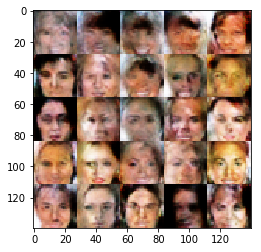

Epoch  0 - Completed  1410  batches
Discriminator Loss:  1.08357
Generator Loss:  1.07402
Epoch  0 - Completed  1420  batches
Discriminator Loss:  1.2124
Generator Loss:  1.27228
Epoch  0 - Completed  1430  batches
Discriminator Loss:  1.31969
Generator Loss:  2.69107
Epoch  0 - Completed  1440  batches
Discriminator Loss:  1.51712
Generator Loss:  0.726841
Epoch  0 - Completed  1450  batches
Discriminator Loss:  1.29728
Generator Loss:  1.10124
Epoch  0 - Completed  1460  batches
Discriminator Loss:  1.14363
Generator Loss:  1.12139
Epoch  0 - Completed  1470  batches
Discriminator Loss:  1.29927
Generator Loss:  1.13654
Epoch  0 - Completed  1480  batches
Discriminator Loss:  1.42001
Generator Loss:  0.957849
Epoch  0 - Completed  1490  batches
Discriminator Loss:  1.14321
Generator Loss:  1.0226
Epoch  0 - Completed  1500  batches
Discriminator Loss:  1.22023
Generator Loss:  1.22429


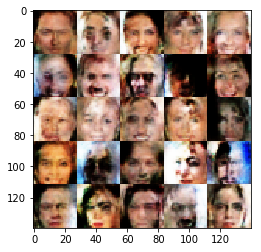

Epoch  0 - Completed  1510  batches
Discriminator Loss:  0.945664
Generator Loss:  1.62676
Epoch  0 - Completed  1520  batches
Discriminator Loss:  1.18071
Generator Loss:  0.954672
Epoch  0 - Completed  1530  batches
Discriminator Loss:  1.57469
Generator Loss:  0.832547
Epoch  0 - Completed  1540  batches
Discriminator Loss:  1.33466
Generator Loss:  1.35415
Epoch  0 - Completed  1550  batches
Discriminator Loss:  1.20086
Generator Loss:  0.925228
Epoch  0 - Completed  1560  batches
Discriminator Loss:  1.30396
Generator Loss:  1.03275
Epoch  0 - Completed  1570  batches
Discriminator Loss:  1.1618
Generator Loss:  1.90145
Epoch  0 - Completed  1580  batches
Discriminator Loss:  0.738627
Generator Loss:  2.14352


In [116]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.